In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds
import random
import datetime
import pandas as pd

from data_processing import create_training_split, df_training_split, train_valid_test_split, df_train_valid_test_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr
from lstm_model import build_open_loop_lstm, load_open_loop_lstm

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## DATA
- Data is generated in Lorenz_data_creation.ipynb
- 4D Data (t,x,y,z)
- Data is normalized with respect to max(abs())

In [148]:
mydf = np.genfromtxt('CSV/13333_lorenz_normalized.csv',delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
print("Shape of discrete time step array ", time.shape)
print("Shape of solution array: ", mydf.shape)

Shape of discrete time step array  (13333,)
Shape of solution array:  (3, 13333)


## Data Preprocessing
- training/ testation split 70/30

In [149]:
df_train, df_valid, df_test = df_train_valid_test_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0,:])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])

### Windowing
- split the sequential data into windows to be fed into the network in batches
- Batch size of 32, Window size of 50, 3D entries

In [150]:
# Transposition needed for windowing of 3D data
df_train_transposed = df_train.transpose()
df_test_transposed = df_test.transpose()

In [151]:
def create_df_3d(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    #dataset = dataset.shuffle(7).map(lambda window: (window[:-1], window[-1]))#separates each window into features and label (next/last value)
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None, 3],[3]))
    return dataset

In [152]:
window_size=50
batch_size=32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train_transposed, window_size, batch_size, shuffle_buffer_size)
valid_dataset = create_df_3d(df_valid.transpose(), window_size, batch_size, 1)
test_dataset = create_df_3d(df_test_transposed, window_size, batch_size, 1)

## MODEL & TRAINING
- build LSTM (same dim as window = 50)
- train LSTM (epochs?)

In [153]:
print(len(list(train_dataset)))
for example_inputs, example_labels in train_dataset.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
print(len(list(valid_dataset)))
for example_inputs, example_labels in valid_dataset.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
print(len(list(test_dataset)))
for example_inputs, example_labels in test_dataset.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

249
Inputs shape (batch, time, features): (32, 50, 3)
Labels shape (batch, time, features): (32, 3)
82
Inputs shape (batch, time, features): (32, 50, 3)
Labels shape (batch, time, features): (32, 3)
82
Inputs shape (batch, time, features): (32, 50, 3)
Labels shape (batch, time, features): (32, 3)


In [170]:
def custom_loss(y_true, y_pred, washout=0):
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(y_true[washout:, :], y_pred[washout:, :])  # (batchsize, dimensions)
    return loss

In [171]:
def build_open_loop_lstm():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', name='LSTM_1'),
        tf.keras.layers.Dense(3, name='Dense_1')
        ])
    optimizer = tf.keras.optimizers.Adam()
    mse_loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=custom_loss, optimizer=optimizer, metrics=['mse'])
    return model

model_oloop = build_open_loop_lstm()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model_oloop.fit(train_dataset, epochs=100, batch_size=batch_size, validation_data=valid_dataset, callbacks=[tensorboard_callback])#, early_stop_callback])
model_oloop.summary()

Epoch 1/100
249/249 [==============================] - 4s 14ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/100
249/249 [==============================] - 4s 15ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/100
249/249 [==============================] - 3s 14ms/step - loss: 8.2616e-04 - mse: 8.2616e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/100
249/249 [==============================] - 3s 14ms/step - loss: 6.7081e-04 - mse: 6.7081e-04 - val_loss: 3.7175e-04 - val_mse: 3.7175e-04
Epoch 5/100
249/249 [==============================] - 3s 14ms/step - loss: 2.0576e-04 - mse: 2.0576e-04 - val_loss: 5.2627e-04 - val_mse: 5.2627e-04
Epoch 6/100
249/249 [==============================] - 3s 14ms/step - loss: 2.7566e-04 - mse: 2.7566e-04 - val_loss: 4.7545e-04 - val_mse: 4.7545e-04
Epoch 7/100
249/249 [==============================] - 3s 13ms/step - loss: 1.9335e-04 - mse: 1.9335e-04 - val_loss: 6.5826e-04 - val_mse: 6

In [100]:
pd.DataFrame(history.history).to_csv("oloop_lstm_washout3/train_history_100.csv")
hist = pd.read_csv("oloop_lstm_washout3/train_history_100.csv")

In [76]:

%tensorboard --logdir logs/fit

In [186]:
model_checkpoint = 'models/oloop_lstm/200_epoch_cp'
# Save the weights
#model_oloop.save_weights(model_checkpoint)

In [187]:
# Create a new model instance
model = build_open_loop_lstm()

# Restore the weights
model.load_weights(model_checkpoint)

## EVALUATE
Use the LSTM model to predict and plot the testation data. 

In [172]:
model = model_oloop

In [190]:
def create_window_closed_loop(test_data, iteration, pred=np.array([])):
    if iteration == 0:
        print("no network prediction yet")
        return test_data[:50, :].reshape(1, 50, 3)
    if iteration < 50:
        n_pred = pred.shape[0]
        idx_test_entries = iteration + 50 - n_pred  # end index of entries from the test data, 
        test_data = test_data[iteration: idx_test_entries , :]
        return np.append(test_data, pred, axis=0).reshape(1, 50, 3)
    else:
        return pred[-50:,:].reshape(1, 50, 3)

def add_new_pred(pred_old, pred_new):
    return np.append(pred_old,pred_new, axis=0)

In [191]:
def closed_loop_loss(true_val, pred_val):
    return tf.keras.metrics.mean_squared_error(true_val, pred_val)

In [192]:
def select_random_window_with_label(df_transposed, n_windows):
    idx = random.sample(range(len(df_transposed)-50-1), n_windows)
    #window_list =[]
    window_list = [df_transposed[i:i+50, :].reshape(1, 50, 3) for i in idx]
    label_list = [df_transposed[i+51, :].reshape(1, 3) for i in idx]
    return window_list, label_list, idx

def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array([np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :], predictions[i, :].reshape(1,3), axis=0).reshape(50, 3) for i in range(0,len(idx))])
    label_list = np.array([df_transposed[i+52, :] for i in idx])
    return window_list, label_list

In [203]:
test_window = create_window_closed_loop(df_test.transpose(), 0)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
for iteration in range(1,1000):
    test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    #new_loss = closed_loop_loss(df_test[:, iteration+1], new_pred)
    #print(new_loss)
    #model.compile(loss=new_loss, optimizer='adam')
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

no network prediction yet


(1000, 3)

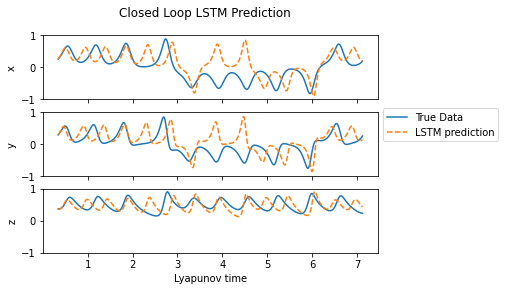

In [204]:
pred_closed_loop = predictions
test_time_end = len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
ax1.plot(lyapunov_time[:test_time_end],x_test[50:50+test_time_end], label='True Data')
ax1.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,0],'--', label='RNN Prediction')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end],y_test[50:50+test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],z_test[50:50+test_time_end], label='True Data')
ax3.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1,1)
#ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

In [37]:

test_window = create_window_closed_loop(df_test.transpose(), 0) # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
predictions.shape

no network prediction yet


(1, 3)

In [ ]:
def select_random_window_bathjes_with_label(df_transposed, n_batches=5, cloop_step=1, batch_size=32):
    idx = random.sample(range(len(df_transposed)-50-1), n_batches*batch_size)
    #window_list =[]
    window_list = [df_transposed[i:i+50, :].reshape(1, 50, 3) for i in idx]
    label_list = [df_transposed[i+51, :].reshape(1, 3) for i in idx]
    return window_list, label_list, idx


def add_cloop_prediction(df_transposed, idx, predictions):
    window_list = np.array([np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :], predictions[i, :].reshape(1,3), axis=0).reshape(50, 3) for i in range(0,len(idx))])
    label_list = np.array([df_transposed[i+52, :] for i in idx])
    return window_list, label_list

In [240]:
cloop_size = 32*10
test_window, labels, idx = select_random_window_with_label(df_train.transpose(), cloop_size) # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(np.array(test_window).reshape(cloop_size,50,3))

print(predictions.shape)
cloop_windows, cloop_label = add_cloop_prediction(df_train.transpose(), idx, predictions)
print(np.array(cloop_windows).shape, cloop_label.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss='mse', optimizer='adam', metric='mse')
model.fit(cloop_windows, cloop_label, epochs=100, batch_size=32, validation_data=valid_dataset, callbacks=[tensorboard_callback])#, early_stop_callback])
model.summary()

(320, 3)
(320, 50, 3) (320, 3)
Epoch 1/100
10/10 [==============================] - 1s 63ms/step - loss: 2.8814e-05 - val_loss: 1.5148e-04
Epoch 2/100
10/10 [==============================] - 0s 45ms/step - loss: 8.1811e-06 - val_loss: 1.5722e-04
Epoch 3/100
10/10 [==============================] - 0s 46ms/step - loss: 4.2988e-06 - val_loss: 1.4233e-04
Epoch 4/100
10/10 [==============================] - 0s 46ms/step - loss: 2.3391e-06 - val_loss: 1.4093e-04
Epoch 5/100
10/10 [==============================] - 0s 45ms/step - loss: 1.6859e-06 - val_loss: 1.5210e-04
Epoch 6/100
10/10 [==============================] - 0s 45ms/step - loss: 1.0696e-06 - val_loss: 1.4772e-04
Epoch 7/100
10/10 [==============================] - 0s 45ms/step - loss: 8.3333e-07 - val_loss: 1.4563e-04
Epoch 8/100
10/10 [==============================] - 0s 45ms/step - loss: 7.6332e-07 - val_loss: 1.4810e-04
Epoch 9/100
10/10 [==============================] - 0s 45ms/step - loss: 6.3723e-07 - val_loss: 1.4648e-

In [214]:
windows, label = add_cloop_prediction(df_train.transpose(), idx, predictions)
#window_list = [np.append(df_train.transpose()[idx[i]+1:idx[i]+50, :], predictions[i, :].reshape(1,3), axis=0).reshape(1, 50, 3) for i in range(0,len(idx))]

In [215]:
model=model_oloop

In [241]:
test_window = create_window_closed_loop(df_test.transpose(), 0)  # np.append(df_train[:, -50:], df_test, axis=1)
predictions = model.predict(test_window)
for iteration in range(1,2000):
    test_window = create_window_closed_loop(df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

no network prediction yet


(2000, 3)

In [237]:
predictions[0,:]

array([0.25904465, 0.2804872 , 0.37170288], dtype=float32)

In [238]:
df_test[:, 50]

array([0.25985738, 0.28593242, 0.37619455])

In [163]:
np.linalg.norm(df_test[:, 50]-forecast[0,:])

0.05886631428441446

In [164]:
forecast=model.predict(test_dataset)
forecast[0,:]

array([0.22471848, 0.25242862, 0.34290797], dtype=float32)

(2617,)


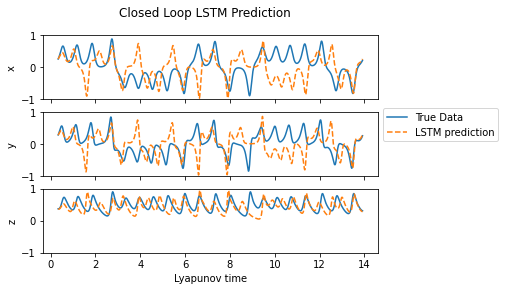

In [239]:
lyapunov_time = compute_lyapunov_time_arr(time_test)
print(lyapunov_time.shape)
pred_closed_loop = predictions
test_time_end = len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
ax1.plot(lyapunov_time[:test_time_end],x_test[50:50+test_time_end], label='True Data')
ax1.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,0],'--', label='RNN Prediction')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end],y_test[50:50+test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],z_test[50:50+test_time_end], label='True Data')
ax3.plot(lyapunov_time[:test_time_end],pred_closed_loop[:,2],'--', label='LSTM prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1,1)
#ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

In [14]:
model=model_oloop

In [18]:
forecast.shape

(1950, 3)

(2000,)

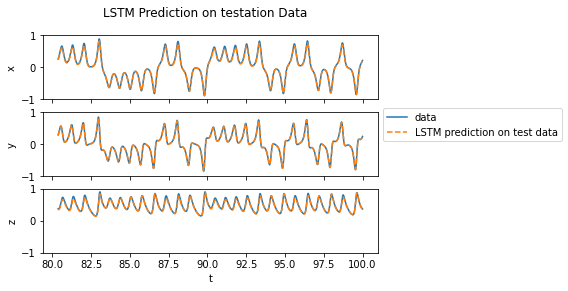

In [181]:
forecast=model.predict(test_dataset)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor="white")#, figsize=(15, 15))
fig.suptitle('LSTM Prediction on testation Data')
ax1.plot(time_test[50:],x_test[50:], label='data')
ax1.plot(time_test[50:],forecast[:,0],'--', label='RNN prediction on test data')
ax1.set_ylabel('x')
ax2.plot(time_test[50:],y_test[50:], label='data')
ax2.plot(time_test[50:],forecast[:,1],'--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:],z_test[50:], label='data')
ax3.plot(time_test[50:],forecast[:,2],'--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
#fig.savefig(testation_filepath, dpi=1000, facecolor="w", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


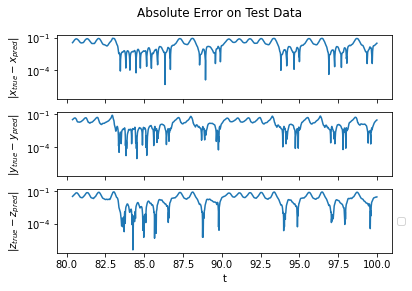

In [168]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor='w')#, figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


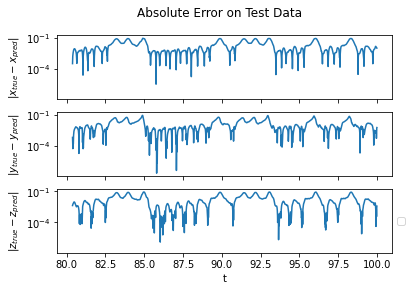

In [169]:
forecast=model.predict(valid_dataset)
err = df_valid.transpose()[50:, :] - forecast
abs_error = np.abs(df_valid.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, facecolor='w')#, figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")